## 1. Preparation

In [3]:
import requests
from bs4 import BeautifulSoup

import pandas as pd # for data analsysis
import numpy as np # to handle data in a vectorized manner

import json # to handle JSON files
import collections # to container datatypes

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # for geocoding
import folium # map rendering

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
#!pip install geocoder

In [5]:
# Foursquare ID and Secret
CLIENT_ID = 'YWWZ1AVGYB25CWFUOJBFHTLGLZCX5OLD5WWJZM0MGFVLW2YS'
CLIENT_SECRET = 'HOD1HC5WESJ02RVVER3K0OSHVSVSRV5M2UUO5FRN10ZKPCF0'

# Foursquare API version
VERSION = '20180605'
# A default Foursquare API limit value
LIMIT = 100

## 2. Load, transform and clean data

### 2.1 Foursquare's Venue Categories

Get Foursquare's Venue Categories.

In [6]:
# url of Foursquare's Venue Categories
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)            

# make the GET request
results = requests.get(url).json()['response']['categories']
#results

Transform them to get an overview of the categories and subcategories.

In [7]:
cat_table = pd.DataFrame(columns={'Categorie', 'Amount of Subcategories'})
categories = []
subcategories = []
cat_dict = {}
for cat_name in results:
    categories.append(cat_name['name'])
    count_sub_cat = 0
    for sub_cat_name in cat_name['categories']:
        subcategories.append(sub_cat_name['name'])
        count_sub_cat = count_sub_cat + 1
        cat_dict.update({sub_cat_name['name']: cat_name['name']})
    cat_table = cat_table.append({'Categorie': cat_name['name'], 'Amount of Subcategories':  count_sub_cat}, ignore_index=True)
cat_table = cat_table[['Categorie', 'Amount of Subcategories']]
print('In general, there are {} categories and {} subcategories'.format(len(categories), len(subcategories)), '\n')
print('The categories are: \n', categories, '\n')
print('The first ten subcategories are: \n', subcategories[:10], '\n')
print('Overview of the amount of subcategories:')
cat_table

In general, there are 10 categories and 470 subcategories 

The categories are: 
 ['Arts & Entertainment', 'College & University', 'Event', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Professional & Other Places', 'Residence', 'Shop & Service', 'Travel & Transport'] 

The first ten subcategories are: 
 ['Amphitheater', 'Aquarium', 'Arcade', 'Art Gallery', 'Bowling Alley', 'Casino', 'Circus', 'Comedy Club', 'Concert Hall', 'Country Dance Club'] 

Overview of the amount of subcategories:


,Categorie,Amount of Subcategories
0,Arts & Entertainment,38
1,College & University,23
2,Event,12
3,Food,92
4,Nightlife Spot,7
5,Outdoors & Recreation,66
6,Professional & Other Places,44
7,Residence,5
8,Shop & Service,147
9,Travel & Transport,36


### 2.2. Load New Yorks's neighborhood geo-coordinates

Load the data.

In [10]:
import os
os.chdir('C:/Users/emrem/Desktop/Emre_Dosyalar/5_Python/Coursera/Coursera_Capstone_Project/')

In [11]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

The features key is a list of the neighborhoods. Transforming this data into a pandas dataframe.

In [12]:
ny_neigh_data = newyork_data['features']
# define the dataframe columns
ny_neigh = pd.DataFrame(columns=['Borough', 'Neighborhood', 'Latitude', 'Longitude'])

Loop through the data and fill the dataframe one row at a time.

In [13]:
for data in ny_neigh_data:
    borough = ny_neigh_name = data['properties']['borough'] 
    ny_neigh_name = data['properties']['name']
        
    ny_neigh_latlon = data['geometry']['coordinates']
    ny_neigh_lat = ny_neigh_latlon[1]
    ny_neigh_lon = ny_neigh_latlon[0]
    
    ny_neigh = ny_neigh.append({'Borough': borough,
                                          'Neighborhood': ny_neigh_name,
                                          'Latitude': ny_neigh_lat,
                                          'Longitude': ny_neigh_lon}, ignore_index=True)
ny_neigh.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [14]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(ny_neigh['Borough'].unique()), ny_neigh.shape[0]))
print('The boroughs are:', ny_neigh.Borough.unique())

The dataframe has 5 boroughs and 306 neighborhoods.
The boroughs are: ['Bronx' 'Manhattan' 'Brooklyn' 'Queens' 'Staten Island']


Get the geograpical coordinates of New York City. The coordinates will be also the coordinates of Mr. Miller's Home.

In [15]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
ny_location = geolocator.geocode(address)
ny_latitude = ny_location.latitude
ny_longitude = ny_location.longitude
print('The geograpical coordinates of Miller\'s Home are {}, {}.'.format(ny_latitude, ny_longitude))

The geograpical coordinates of Miller's Home are 40.7127281, -74.0060152.


### 2.3. Load Toronto's neighborhood geo-coordinates

Scrap data from wikipedia.

In [17]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

html_data = requests.get(URL)
soup = BeautifulSoup(html_data.text, 'html.parser')

title = soup.title

toronto_data = pd.read_html(str(soup.table))[0]
toronto_data.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Clean the data.

In [18]:
# rename column
toronto_data.rename(columns={"Postal Code": "PostalCode", "Neighbourhood": "Neighborhood"}, inplace=True)
print('The columns of the dataframe are:', toronto_data.columns)

# drop rows where Borough == 'Not assigned'
toronto_data.drop(toronto_data[toronto_data.Borough == 'Not assigned'].index, inplace=True)

# groupby
toronto_data = toronto_data.groupby(['PostalCode', 'Borough']).agg(', '.join)
toronto_data.reset_index(inplace = True)

# neighborhood will be the same as the borough, if Neighborhood == 'Not assigned'
toronto_data.loc[toronto_data.loc[toronto_data.Neighborhood == 'Not assigned'].index, 'Neighborhood'] = toronto_data.loc[toronto_data.Neighborhood == 'Not assigned'].Borough

# reset index
toronto_data.reset_index(drop=True, inplace=True)

print('Number of rows and columns: ', toronto_data.shape)
toronto_data.head()

The columns of the dataframe are: Index(['PostalCode', 'Borough', 'Neighborhood'], dtype='object')
Number of rows and columns:  (103, 3)


,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Get the geograpical coordinate of each Borough.

In [19]:
toronto_neigh = toronto_data.copy()
toronto_neigh['Latitude'] = ''
toronto_neigh['Longitude'] = ''

# loop all PostalCodes
for postal_code in toronto_neigh.PostalCode:
    # initialize a variable to None
    lat_lng_coords = None

    # loop until getting the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng

    # add latitude and longitude to dataframe
    index = toronto_neigh.loc[toronto_neigh.PostalCode == postal_code].index[0]
    toronto_latitude = lat_lng_coords[0]
    toronto_neigh.at[index, 'Latitude'] = toronto_latitude
    toronto_longitude = lat_lng_coords[1]
    toronto_neigh.at[index, 'Longitude'] = toronto_longitude
print('Number of rows and columns: ', toronto_neigh.shape)
toronto_neigh.head()

Number of rows and columns:  (103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.8114,-79.1966
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.7857,-79.1587
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.7658,-79.1747
3,M1G,Scarborough,Woburn,43.7681,-79.2176
4,M1H,Scarborough,Cedarbrae,43.7694,-79.2389


In [20]:
print('Amount of boroughs', len(toronto_neigh.Borough.unique()))
print('The boroughs are:', toronto_neigh.Borough.unique())

Amount of boroughs 11
The boroughs are: ['Scarborough' 'North York' 'East York' 'East Toronto' 'Central Toronto'
 'Downtown Toronto' 'York' 'West Toronto' 'Toronto/York' 'Mississauga'
 'Etobicoke']


Get the geograpical coordinates of Toronto. The coordinates will be also the coordinates of Mr. Miller's new company.

In [21]:
#Use geopy library to get the latitude and longitude values of Toronto.
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
toronto_location = geolocator.geocode(address)
toronto_latitude = toronto_location.latitude
toronto_longitude = toronto_location.longitude
print('The geograpical coordinates of Mr. Miller\'s new company are {}, {}.'.format(toronto_latitude, toronto_longitude))

The geograpical coordinates of Mr. Miller's new company are 43.6534817, -79.3839347.


## 3. Explore Toronto's neighborhoods using FourSquare API

Create a function to repeat the exploration to all the neighborhoods.

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):          
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

Run the above function on each neighborhood of Toronto and create a new dataframe.

In [23]:
toronto_venues = getNearbyVenues(toronto_neigh['Neighborhood'], toronto_neigh['Latitude'], toronto_neigh['Longitude'])
print('There are {} uniques subcategories.'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues.head()

There are 337 uniques subcategories.


,Neighborhood,Venue,Venue Category
0,"Malvern, Rouge",Canadiana exhibit,Zoo Exhibit
1,"Malvern, Rouge",Wendy’s,Fast Food Restaurant
2,"Malvern, Rouge",Grizzly Bear Exhibit,Zoo Exhibit
3,"Malvern, Rouge",Upper Rouge Trail,Trail
4,"Malvern, Rouge",Lee Valley,Hobby Shop


Check how many venues were returned for each neighborhood.

In [24]:
toronto_venues.groupby('Neighborhood').count().head()

,Venue,Venue Category
Neighborhood,,
Agincourt,39,39
"Alderwood, Long Branch",26,26
"Bathurst Manor, Wilson Heights, Downsview North",34,34
Bayview Village,7,7
"Bedford Park, Lawrence Manor East",36,36


Epxlore neighborhood "Malvern, Rouge".

In [25]:
Malvern_Rouge_neigh = toronto_venues.Neighborhood[0]
Malvern_Rouge = toronto_venues[toronto_venues.Neighborhood == Malvern_Rouge_neigh]
print('There are {} uniques subcategories.'.format(len(Malvern_Rouge['Venue Category'].unique())))
print('These are:', Malvern_Rouge['Venue Category'].unique())
Malvern_Rouge.head()

There are 4 uniques subcategories.
These are: ['Zoo Exhibit' 'Fast Food Restaurant' 'Trail' 'Hobby Shop']


,Neighborhood,Venue,Venue Category
0,"Malvern, Rouge",Canadiana exhibit,Zoo Exhibit
1,"Malvern, Rouge",Wendy’s,Fast Food Restaurant
2,"Malvern, Rouge",Grizzly Bear Exhibit,Zoo Exhibit
3,"Malvern, Rouge",Upper Rouge Trail,Trail
4,"Malvern, Rouge",Lee Valley,Hobby Shop


## 4. Analyze each neighborhood

In [26]:
# concatonate the subcategories with the neighborhood
cat_df = pd.DataFrame({'Venue Category' : subcategories})
toronto_cat_concat = pd.concat([toronto_venues[toronto_venues['Venue Category'].isin(subcategories)], cat_df], ignore_index = True, sort=True)

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_cat_concat[['Venue Category']], prefix="", prefix_sep="")

# remove the dummy rows
toronto_onehot = toronto_onehot[:-len(subcategories)] 

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
cols=list(toronto_onehot.columns.values)
cols.pop(cols.index('Neighborhood'))
toronto_onehot=toronto_onehot[['Neighborhood']+cols]

toronto_onehot.head()

,Neighborhood,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Architecture Firm,Armenian Restaurant,Art Gallery,Art Studio,Arts & Crafts Store,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baggage Locker,Bakery,Ballroom,Bangladeshi Restaurant,Bank,Bar,Bath House,Bathing Area,Batik Shop,Bay,Beach,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Launch,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Center,Business Service,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Check Cashing Service,Child Care Service,Chocolate Shop,Christmas Market,Cidery,Circus,Clothing Store,Club House,Coffee Shop,College Academic Building,College Administrative Building,College Auditorium,College Bookstore,College Cafeteria,College Classroom,College Gym,College Lab,College Library,College Quad,College Rec Center,College Residence Hall,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Conference,Construction & Landscaping,Convenience Store,Convention,Convention Center,Cosmetics Shop,Costume Shop,Country Dance Club,Credit Union,Creperie,Cruise Ship,Cultural Center,Currency Exchange,Czech Restaurant,Dam,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Shop,Dive Spot,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Duty-free Shop,EV Charging Station,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Escape Room,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Fast Food Restaurant,Festival,Field,Film Studio,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,Frame Store,Fraternity House,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Government Building,Greek Restaurant,Gun Range,Gun Shop,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Herbs & Spices Store,Hill,Historic Site,Hobby Shop,Home (private),Home Service,Hot Dog Joint,Hot Spring,Hotel,Housing Development,Hungarian Restaurant,Hunting Supply,IT Services,Indian Restaurant,Indoor Play Area,Industrial Estate,Insurance Office,Internet Cafe,Intersection,Irish Pub,Island,Italian Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Box,Kebab Restaurant,Kitchen Supply Store,Knitting Store,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Law School,Lawyer,Leather Goods Store,Library,Light Rail Station,Lighthouse,Line / Queue,Locksmith,Lottery Retailer,Lounge,Luggage Store,Mac & Cheese Joint,Marijuana Dispensary,Marine Terminal,Market,Massage Studio,Mattress Store,Meadery,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Mobility Store,Modern European Restaurant,Molecular Gastronomy Restaurant,Motorcycle Shop,Motorsport

Group rows by neighborhood and by taking the sum of each subcategory.

In [27]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').sum()
toronto_grouped.head()

,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Architecture Firm,Armenian Restaurant,Art Gallery,Art Studio,Arts & Crafts Store,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baggage Locker,Bakery,Ballroom,Bangladeshi Restaurant,Bank,Bar,Bath House,Bathing Area,Batik Shop,Bay,Beach,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Launch,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Center,Business Service,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Check Cashing Service,Child Care Service,Chocolate Shop,Christmas Market,Cidery,Circus,Clothing Store,Club House,Coffee Shop,College Academic Building,College Administrative Building,College Auditorium,College Bookstore,College Cafeteria,College Classroom,College Gym,College Lab,College Library,College Quad,College Rec Center,College Residence Hall,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Conference,Construction & Landscaping,Convenience Store,Convention,Convention Center,Cosmetics Shop,Costume Shop,Country Dance Club,Credit Union,Creperie,Cruise Ship,Cultural Center,Currency Exchange,Czech Restaurant,Dam,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Shop,Dive Spot,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Duty-free Shop,EV Charging Station,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Escape Room,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Fast Food Restaurant,Festival,Field,Film Studio,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,Frame Store,Fraternity House,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Government Building,Greek Restaurant,Gun Range,Gun Shop,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Herbs & Spices Store,Hill,Historic Site,Hobby Shop,Home (private),Home Service,Hot Dog Joint,Hot Spring,Hotel,Housing Development,Hungarian Restaurant,Hunting Supply,IT Services,Indian Restaurant,Indoor Play Area,Industrial Estate,Insurance Office,Internet Cafe,Intersection,Irish Pub,Island,Italian Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Box,Kebab Restaurant,Kitchen Supply Store,Knitting Store,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Law School,Lawyer,Leather Goods Store,Library,Light Rail Station,Lighthouse,Line / Queue,Locksmith,Lottery Retailer,Lounge,Luggage Store,Mac & Cheese Joint,Marijuana Dispensary,Marine Terminal,Market,Massage Studio,Mattress Store,Meadery,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Mobility Store,Modern European Restaurant,Molecular Gastronomy Restaurant,Motorcycle Shop,Motorsports Shop,Mounta

## 5. Clustering

Transform features.

In [28]:
scaler = StandardScaler()
X = scaler.fit_transform(toronto_grouped.astype(float))

### 5.1. DBSCAN

Run Density-based Clustering to cluster the neighborhood.

In [29]:
db = DBSCAN(eps=0.5, min_samples=2).fit(X)
labels = db.labels_
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))
print('Number of Cluster: ', clusterNum)

Number of Cluster:  1


DBSCAN is not a good choice of clustering, because there is only one cluster.

### 5.2. KMeans

Run KMeans to cluster the neighborhood into 10 clusters.

In [30]:
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=5).fit(X)
labels = kmeans.labels_
clusterNum = len(set(labels))
collection = collections.Counter(labels)
print('Number of Cluster: ', clusterNum)
print(collection)

Number of Cluster:  10
Counter({0: 50, 5: 8, 6: 5, 4: 1, 3: 1, 1: 1, 8: 1, 7: 1, 9: 1, 2: 1})


With KMenas we get ten cluster, so in following we choose this clustering method.  
Merge to add latitude/longitude for each neighborhood.

In [31]:
toronto_clustered = toronto_grouped.copy()

# add clustering labels
toronto_clustered.insert(0, 'Cluster Labels', labels)

# merge toronto_neigh with toronto_clustered to add latitude/longitude for each neighborhood
toronto_merged = toronto_neigh.set_index('Neighborhood').join(toronto_clustered, how='right')

toronto_merged.head()

,PostalCode,Borough,Latitude,Longitude,Cluster Labels,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Architecture Firm,Armenian Restaurant,Art Gallery,Art Studio,Arts & Crafts Store,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baggage Locker,Bakery,Ballroom,Bangladeshi Restaurant,Bank,Bar,Bath House,Bathing Area,Batik Shop,Bay,Beach,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Launch,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Center,Business Service,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Check Cashing Service,Child Care Service,Chocolate Shop,Christmas Market,Cidery,Circus,Clothing Store,Club House,Coffee Shop,College Academic Building,College Administrative Building,College Auditorium,College Bookstore,College Cafeteria,College Classroom,College Gym,College Lab,College Library,College Quad,College Rec Center,College Residence Hall,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Conference,Construction & Landscaping,Convenience Store,Convention,Convention Center,Cosmetics Shop,Costume Shop,Country Dance Club,Credit Union,Creperie,Cruise Ship,Cultural Center,Currency Exchange,Czech Restaurant,Dam,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Shop,Dive Spot,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Duty-free Shop,EV Charging Station,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Escape Room,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Fast Food Restaurant,Festival,Field,Film Studio,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,Frame Store,Fraternity House,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Government Building,Greek Restaurant,Gun Range,Gun Shop,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Herbs & Spices Store,Hill,Historic Site,Hobby Shop,Home (private),Home Service,Hot Dog Joint,Hot Spring,Hotel,Housing Development,Hungarian Restaurant,Hunting Supply,IT Services,Indian Restaurant,Indoor Play Area,Industrial Estate,Insurance Office,Internet Cafe,Intersection,Irish Pub,Island,Italian Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Box,Kebab Restaurant,Kitchen Supply Store,Knitting Store,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Law School,Lawyer,Leather Goods Store,Library,Light Rail Station,Lighthouse,Line / Queue,Locksmith,Lottery Retailer,Lounge,Luggage Store,Mac & Cheese Joint,Marijuana Dispensary,Marine Terminal,Market,Massage Studio,Mattress Store,Meadery,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Mobility Store,Modern European Restaurant,Molecular Gastrono

Visualisation of Toronto and its cluster.

In [32]:
# create map
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged.index.values, toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 6. Explore New York's neighborhoods using FourSquare API

Now we have to explore the New York's neighborhoods, because of the current home of Mr. Miller.  
We need this to compare the similarities.

In [33]:
home_venues = getNearbyVenues(['Millers Home'],[ny_latitude], [ny_longitude])

cat_df = pd.DataFrame({'Venue Category' : subcategories})
ny_cat_concat = pd.concat([home_venues[home_venues['Venue Category'].isin(subcategories)], cat_df], ignore_index = True, sort=True)

# one hot encoding
ny_onehot = pd.get_dummies(ny_cat_concat[['Venue Category']], prefix="", prefix_sep="")

# remove the dummy rows
ny_onehot = ny_onehot[:-len(subcategories)] 

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = home_venues['Neighborhood'] 

# move neighborhood column to the first column
cols=list(ny_onehot.columns.values)
cols.pop(cols.index('Neighborhood'))
ny_onehot=ny_onehot[['Neighborhood']+cols]

ny_grouped = ny_onehot.groupby('Neighborhood').sum() #.reset_index()
ny_grouped.head()

,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Architecture Firm,Armenian Restaurant,Art Gallery,Art Studio,Arts & Crafts Store,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baggage Locker,Bakery,Ballroom,Bangladeshi Restaurant,Bank,Bar,Bath House,Bathing Area,Batik Shop,Bay,Beach,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Launch,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Center,Business Service,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Check Cashing Service,Child Care Service,Chocolate Shop,Christmas Market,Cidery,Circus,Clothing Store,Club House,Coffee Shop,College Academic Building,College Administrative Building,College Auditorium,College Bookstore,College Cafeteria,College Classroom,College Gym,College Lab,College Library,College Quad,College Rec Center,College Residence Hall,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Conference,Construction & Landscaping,Convenience Store,Convention,Convention Center,Cosmetics Shop,Costume Shop,Country Dance Club,Credit Union,Creperie,Cruise Ship,Cultural Center,Currency Exchange,Czech Restaurant,Dam,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Shop,Dive Spot,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Duty-free Shop,EV Charging Station,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Escape Room,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Fast Food Restaurant,Festival,Field,Film Studio,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,Frame Store,Fraternity House,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Government Building,Greek Restaurant,Gun Range,Gun Shop,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Herbs & Spices Store,Hill,Historic Site,Hobby Shop,Home (private),Home Service,Hot Dog Joint,Hot Spring,Hotel,Housing Development,Hungarian Restaurant,Hunting Supply,IT Services,Indian Restaurant,Indoor Play Area,Industrial Estate,Insurance Office,Internet Cafe,Intersection,Irish Pub,Island,Italian Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Box,Kebab Restaurant,Kitchen Supply Store,Knitting Store,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Law School,Lawyer,Leather Goods Store,Library,Light Rail Station,Lighthouse,Line / Queue,Locksmith,Lottery Retailer,Lounge,Luggage Store,Mac & Cheese Joint,Marijuana Dispensary,Marine Terminal,Market,Massage Studio,Mattress Store,Meadery,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Mobility Store,Modern European Restaurant,Molecular Gastronomy Restaurant,Motorcycle Shop,Motorsports Shop,Mounta

## 7. Find best cluster of neighborhoods

In [34]:
X_test = scaler.transform(ny_grouped.astype(float))
y_hat_test = kmeans.predict(X_test)
closest = y_hat_test[0]
print('The closest neighborhoods are in cluster {}, which includes {} neighborhoods in Toronto.'.format(closest, collection[closest]))


The closest neighborhoods are in cluster 0, which includes 50 neighborhoods in Toronto.


## 8. Validation

### 8.1. Visualisation of cluster in map

In [35]:
# Filter data
closest_cluster = toronto_merged[toronto_merged['Cluster Labels'] == closest]
closest_cluster.head()

,PostalCode,Borough,Latitude,Longitude,Cluster Labels,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Architecture Firm,Armenian Restaurant,Art Gallery,Art Studio,Arts & Crafts Store,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baggage Locker,Bakery,Ballroom,Bangladeshi Restaurant,Bank,Bar,Bath House,Bathing Area,Batik Shop,Bay,Beach,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Launch,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Center,Business Service,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Check Cashing Service,Child Care Service,Chocolate Shop,Christmas Market,Cidery,Circus,Clothing Store,Club House,Coffee Shop,College Academic Building,College Administrative Building,College Auditorium,College Bookstore,College Cafeteria,College Classroom,College Gym,College Lab,College Library,College Quad,College Rec Center,College Residence Hall,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Conference,Construction & Landscaping,Convenience Store,Convention,Convention Center,Cosmetics Shop,Costume Shop,Country Dance Club,Credit Union,Creperie,Cruise Ship,Cultural Center,Currency Exchange,Czech Restaurant,Dam,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Shop,Dive Spot,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Duty-free Shop,EV Charging Station,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Escape Room,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Fast Food Restaurant,Festival,Field,Film Studio,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,Frame Store,Fraternity House,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Government Building,Greek Restaurant,Gun Range,Gun Shop,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Herbs & Spices Store,Hill,Historic Site,Hobby Shop,Home (private),Home Service,Hot Dog Joint,Hot Spring,Hotel,Housing Development,Hungarian Restaurant,Hunting Supply,IT Services,Indian Restaurant,Indoor Play Area,Industrial Estate,Insurance Office,Internet Cafe,Intersection,Irish Pub,Island,Italian Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Box,Kebab Restaurant,Kitchen Supply Store,Knitting Store,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Law School,Lawyer,Leather Goods Store,Library,Light Rail Station,Lighthouse,Line / Queue,Locksmith,Lottery Retailer,Lounge,Luggage Store,Mac & Cheese Joint,Marijuana Dispensary,Marine Terminal,Market,Massage Studio,Mattress Store,Meadery,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Mobility Store,Modern European Restaurant,Molecular Gastrono

In [36]:
print('Potential neighborhoods are: \n', closest_cluster.index.values)

Potential neighborhoods are: 
 ['Agincourt' 'Bathurst Manor, Wilson Heights, Downsview North'
 'Bayview Village' 'Bedford Park, Lawrence Manor East'
 'Birch Cliff, Cliffside West' 'Cedarbrae'
 "Clarks Corners, Tam O'Shanter, Sullivan"
 'Cliffside, Cliffcrest, Scarborough Village West' 'Don Mills' 'Don Mills'
 'Dorset Park, Wexford Heights, Scarborough Town Centre' 'Downsview'
 'Downsview' 'Downsview' 'Downsview' 'Fairview, Henry Farm, Oriole'
 'First Canadian Place, Underground city'
 'Forest Hill North & West, Forest Hill Road Park' 'Glencairn'
 'Golden Mile, Clairlea, Oakridge' 'Guildwood, Morningside, West Hill'
 'Hillcrest Village' 'Humewood-Cedarvale' 'India Bazaar, The Beaches West'
 'Kennedy Park, Ionview, East Birchmount Park'
 'Kensington Market, Chinatown, Grange Park'
 'Lawrence Manor, Lawrence Heights' 'Lawrence Park' 'Leaside'
 'Malvern, Rouge'
 "Milliken, Agincourt North, Steeles East, L'Amoreaux East"
 'Northwood Park, York University' 'Parkview Hill, Woodbine Gardens'
 

Visualise the potential neighborhoods in a map.

In [37]:
# create map
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(closest_cluster['Latitude'], closest_cluster['Longitude'], closest_cluster.index.values, closest_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The blue points indecate the closest cluster to Miller's home neighbarhoods.

### 8.2. Visualisation of categories

Compare the frequency of the ten categories of the potential neighborhoods with the current home.

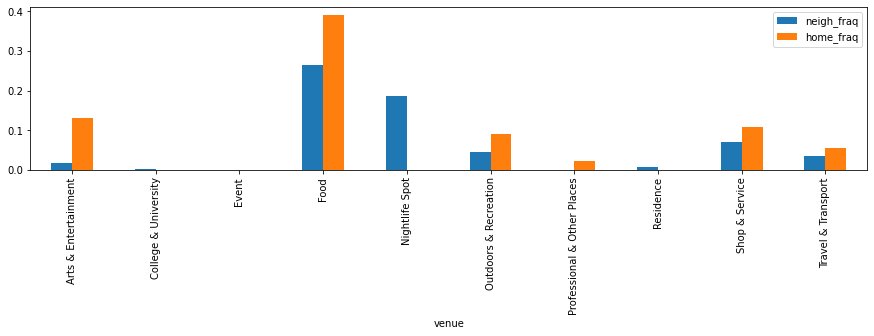

In [38]:
cluster_mean = closest_cluster.groupby('Cluster Labels').mean()
cluster_mean.reset_index(drop=True, inplace=True)
cluster_cat_mean = cluster_mean.groupby(cat_dict, axis = 1).mean().T
cluster_cat_mean.reset_index(drop=False, inplace=True)
cluster_cat_mean.columns = ['venue', 'neigh_fraq']

home_mean = ny_onehot.groupby('Neighborhood').sum()
home_mean.reset_index(drop=True, inplace=True)
home_cat_mean = home_mean.groupby(cat_dict, axis = 1).mean().T
home_cat_mean.reset_index(drop=False, inplace=True)
home_cat_mean.columns = ['venue', 'home_fraq']

cluster_home = cluster_cat_mean.set_index('venue').join(home_cat_mean.set_index('venue'))

cluster_home.plot(kind="bar", figsize=(15,3))

### 8.3. Find similar neighborhood of the best cluster

Look at the five most common venues of Mr. Miller's home.

In [39]:
num_top_venues = 5

# Group by categories
ny_grouped_cat = ny_grouped.groupby(cat_dict, axis = 1).mean()
ny_grouped_cat.reset_index(drop=False, inplace=True)

# Create Dataframe with frequency for the 5 most common venues
print("----Home----")
ny_freq = ny_grouped_cat.T.reset_index()
ny_freq.columns = ['venue','freq']
ny_freq = ny_freq.iloc[1:]
ny_freq['freq'] = ny_freq['freq'].astype(float)
ny_freq = ny_freq.round({'freq': 2})
ny_freq = ny_freq.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
ny_freq

----Home----


,venue,freq
0,Food,0.39
1,Arts & Entertainment,0.13
2,Shop & Service,0.11
3,Outdoors & Recreation,0.09
4,Travel & Transport,0.06


Calculate the mean absolute error to the five most common venues of neighborhoods.

In [40]:
closest_cluster_venues = closest_cluster.drop(columns=['PostalCode', 'Borough', 'Latitude', 'Longitude',  'Cluster Labels'], axis=1)

close_cluster_cat_mean = closest_cluster_venues.groupby(cat_dict, axis = 1).mean()
close_cluster_cat_mean.reset_index(drop=False, inplace=True)

# Mean absolute error
MAE = pd.DataFrame(columns=['Neighborhood', 'Error'])

for hood in close_cluster_cat_mean['Neighborhood'].unique():
    hood_freq = close_cluster_cat_mean[close_cluster_cat_mean['Neighborhood'] == hood].T.reset_index()
    hood_freq = hood_freq.iloc[:, 0:2]
    hood_freq.columns = ['venue','freq_hood']
    hood_freq = hood_freq.iloc[1:]
    hood_freq['freq_hood'] = hood_freq['freq_hood'].astype(float)
    hood_freq = ny_freq.set_index('venue').join(hood_freq.set_index('venue'))
    Error = np.mean(np.absolute(hood_freq['freq_hood'] - hood_freq['freq']))
    MAE = MAE.append({'Neighborhood': hood, 'Error': Error}, ignore_index=True).sort_values('Error', ascending=True)
MAE.head()

,Neighborhood,Error
0,Don Mills,0.040059
1,Woodbine Heights,0.053906
2,Downsview,0.057335
3,Leaside,0.058954
4,"Fairview, Henry Farm, Oriole",0.059835


In [41]:
print('The best neighborhood with the most similarity is:', MAE.Neighborhood[0])

The best neighborhood with the most similarity is: Don Mills


Compare the similar neighborhood with the current home.

<function matplotlib.pyplot.show(*args, **kw)>

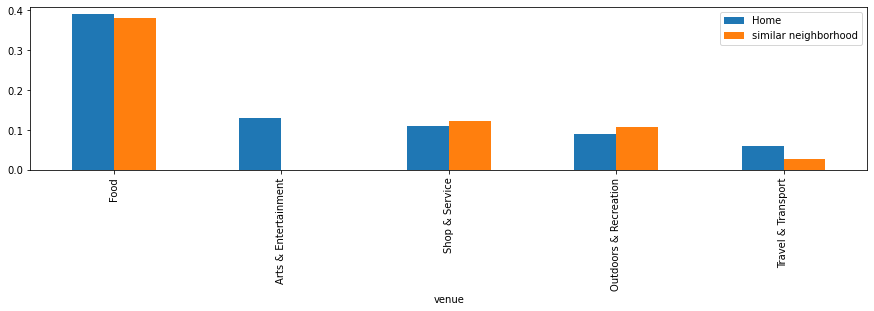

In [42]:
sim_hood = close_cluster_cat_mean[close_cluster_cat_mean['Neighborhood'] == MAE.Neighborhood[0]].T.reset_index()
sim_hood = sim_hood.iloc[:, 0:2]
sim_hood.columns = ['venue','freq_hood']
sim_hood = sim_hood.iloc[1:]
sim_hood['freq_hood'] = sim_hood['freq_hood'].astype(float)
sim_hood = ny_freq.set_index('venue').join(sim_hood.set_index('venue'))

sim_hood.plot(kind="bar", figsize=(15,3))
plt.legend(['Home', 'similar neighborhood'])
plt.show

Visualise the similar neighborhood.

In [43]:
sim_latitude = closest_cluster[closest_cluster.index == MAE.Neighborhood[0]].Latitude.max()
sim_longitude = closest_cluster[closest_cluster.index == MAE.Neighborhood[0]].Longitude.min()

# create map
folium.CircleMarker(
    [sim_latitude, sim_longitude],
    radius=15,
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_clusters)
map_clusters